In [31]:
# pip install requests beautifulsoup4

In [61]:
pip install plotly.express

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 4.5 MB/s eta 0:00:0000:010:01m

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.1.6_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [62]:
import warnings
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [33]:
import pandas as pd
df = pd.read_csv("ds_salaries.csv")

In [34]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


# Beautiful Soup

### For learning purposes i will be doing an extraction of data with Beautiful Soup to learn more about web scraping.
I know, there is a thousand libraries that do the following for me, but as i just said, i am tring to learn a new tool.

So lets create a function to get the most recent currency values and update our salary column to our salary_in_usd with the current value of our salary_currency compared to usd.

In [35]:
#First lets import our requests and BeautifulSoup libraries
import requests
from bs4 import BeautifulSoup

Here we will create our function to get the HTML from the google finance website.
1. We define a function that will recive an url of the currency we want to get the current value;
2. Then we will use the BeautifulSoup method to parse the html content we get from that page;
3. Now we need to find only the data we are interested in, witch is found at a div with class YMlKec fxKbKc, that we can find by inspecting the page with the right click of our mouse;
4. At last we will need this number, so we return it but as a float.

In [36]:
def convert(url):
    html_content = requests.get(url).text
    soup = BeautifulSoup(html_content, "html.parser")
    txt = soup.find('div', attrs = {'class':"YMlKec fxKbKc"})
    return float(txt.text)


# Example that gets the EUR to USD: https://www.google.com/search?client=safari&rls=en&q=eu+to+dolar&ie=UTF-8&oe=UTF-8


In [37]:
df.salary_currency.value_counts()

salary_currency
USD    3224
EUR     236
GBP     161
INR      60
CAD      25
AUD       9
SGD       6
BRL       6
PLN       5
CHF       4
HUF       3
DKK       3
JPY       3
TRY       3
THB       2
ILS       1
HKD       1
CZK       1
MXN       1
CLP       1
Name: count, dtype: int64

Looking into our data we can see that majority of the salary_currency is alreadly in USD, so for even better performance we can get rid of this data for now and work solo into the other currencies.
* We will stash our data of USD into df_usd;
* The other currencies will be stashed at df_other_curr

In [38]:
df_usd = df[df.salary_currency == 'USD']
df_other_curr = df[df.salary_currency != 'USD']
# print(df_usd.salary_currency.value_counts())
# print(df_other_curr.salary_currency.value_counts())

Once we have a lot of different currencies, we will need to alter our url that we will pass to our convert function. 
We can do that by searching where in the url is the currency we are parsing to compare to USD.
* https://www.google.com/finance/quote/EUR-USD?sa=X ved=2ahUKEwi2vqDZ0IaHAxVVr5UCHcXZDFEQmY0JegQICBAw
* Here we see that the currency we are passing is at **EUR**-USD;
* What we are going to do is add a .format() to the url to get each one of the values to each currency.

In [39]:
# First lets get the unique currencies we are working with
df_unique = df_other_curr.salary_currency.unique()
print(df_unique)

['EUR' 'INR' 'HKD' 'CHF' 'GBP' 'AUD' 'SGD' 'CAD' 'ILS' 'BRL' 'THB' 'PLN'
 'HUF' 'CZK' 'DKK' 'JPY' 'MXN' 'TRY' 'CLP']


### Get currency function

1. Our function is going to recive a list of currencies just as the above df_unique;
2. We will create a list to stash the values we will get from the convert function;
3. We create a for loop to iterate our currencies list, there we will append the result from the convert function to the list we just created
    * As i said lets change our url to the following: 
    * https://www.google.com/finance/quote/{}-USD?sa=X ved=2ahUKEwi2vqDZ0IaHAxVVr5UCHcXZDFEQmY0JegQICBAw".format(i)
    * The format.(i) is getting the current currency in our for loop and passing it to the {} in the url, where the currency stays, with this we can get the value for each currency
4. At least, we will create a dictionary to stash each currency to its current value, using:
    * dict_list = dict(zip(data, list))

In [40]:
def get_currency_val(data):
    list = []
    for i in data:
        list.append(convert("https://www.google.com/finance/quote/{}-USD?sa=X&ved=2ahUKEwi2vqDZ0IaHAxVVr5UCHcXZDFEQmY0JegQICBAw".format(i)))
    dic_list = dict(zip(data, list))
    return dic_list

In [53]:
# Calling our get_currency_val passing the unique currencies we will be working with
dict_list = get_currency_val(df_unique)

### Updating our dataset

At last we need to update our df_other_curr with the values we just got from the currencies values, for that we create a simple function that does the following:
1. Recives a row from the dataset
2. If the currency in that row is in our dictionary, we change our salary_in_usd column (row[6]) to the multiplication of the salary column (row[4]) by the corresponding value of our currency dict.
3. Than we return that row just updated
4. To update the dataset we apply the changes with .apply 

In [54]:
def update_row(row):
    if row[5] in dict_list.keys():
        row[6] = row[4] * dict_list[row[5]]
    return row

df_other_curr = df_other_curr.apply(update_row, axis=1)

### And with that we are done with Beautiful Soup for now

We got the information we needed and updated the column we wanted.
Another good thing we did is use functions, so when we want, we can just run them and get the current value almost live again.

Let`s see the dataset again to see if we got it right.

In [55]:
df_other_curr.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,86272.0,ES,100,ES,L
41,2022,MI,FT,Machine Learning Engineer,1650000,INR,19800.0,IN,50,IN,L
80,2023,MI,FT,Data Scientist,510000,HKD,65280.0,HK,0,HK,L
82,2023,MI,FT,Applied Machine Learning Engineer,65000,EUR,70096.0,IN,100,DE,S
84,2023,MI,FT,Machine Learning Engineer,90000,EUR,97056.0,NL,100,NL,L


Now lets unite our df_usd to our df_other_curr to get going with the analysis.

In [86]:
df = pd.concat([df_usd, df_other_curr])

In [87]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
1,2023,MI,CT,ML Engineer,30000,USD,30000.0,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500.0,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000.0,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000.0,CA,100,CA,M
5,2023,SE,FT,Applied Scientist,222200,USD,222200.0,US,0,US,L


In [58]:
df.isna().sum()
df.duplicated().sum()

1171

In [73]:
pip install pycountry -q



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.1.6_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [88]:
import pycountry
def country_code_to_name(country_code):
    try:
        return pycountry.countries.get(alpha2 = country_code).name
    except:
        return country_code
def country_code_to_name(code):
    try:
        country = pycountry.countries.get(alpha_2 = code)
        return country.name
    except:
        return None

In [89]:
df['company_location'] = df['company_location'].apply(country_code_to_name)
df['employee_residence'] = df['employee_residence'].apply(country_code_to_name)

In [90]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
1,2023,MI,CT,ML Engineer,30000,USD,30000.0,United States,100,United States,S
2,2023,MI,CT,ML Engineer,25500,USD,25500.0,United States,100,United States,S
3,2023,SE,FT,Data Scientist,175000,USD,175000.0,Canada,100,Canada,M
4,2023,SE,FT,Data Scientist,120000,USD,120000.0,Canada,100,Canada,M
5,2023,SE,FT,Applied Scientist,222200,USD,222200.0,United States,0,United States,L


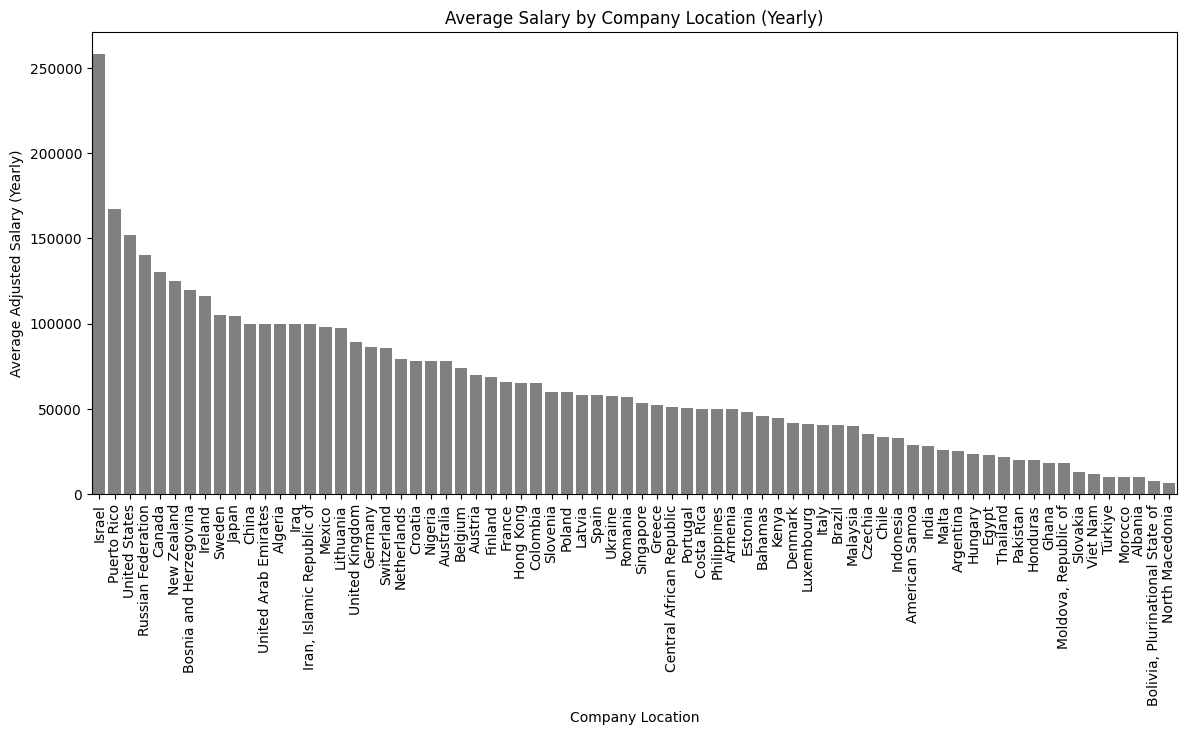

In [91]:

# Average salary by company_location
avg_salary_by_location = df.groupby('company_location', as_index=False)['salary_in_usd'].mean()

fig1 = px.choropleth(avg_salary_by_location,
                     locations='company_location',
                     locationmode='country names',
                     color='salary_in_usd',
                     hover_name='company_location',
                     color_continuous_scale=px.colors.sequential.Plasma,
                     title='Average Salary by Company Location',
                     labels={'salary_in_usd': 'Average Adjusted Salary'},
                     projection='natural earth')

fig1.show()

# Average salary by company_location
avg_salary_by_location = df.groupby('company_location')['salary_in_usd'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 6))
sns.barplot(x=avg_salary_by_location.index, y=avg_salary_by_location, color='grey')
plt.title('Average Salary by Company Location (Yearly)')
plt.xlabel('Company Location')
plt.ylabel('Average Adjusted Salary (Yearly)')
plt.xticks(rotation=90)
plt.show()